# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


In [1]:
%%capture
!pip install scikit-learn
!pip install numpy
!wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
!unzip SST-2.zip

## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [7]:
import pandas as pd

# データの読み込み（タブ区切り、ヘッダーあり）
train_df = pd.read_csv("SST-2/train.tsv", sep='\t', header=0)
dev_df = pd.read_csv("SST-2/dev.tsv", sep='\t', header=0)

# ラベル列の存在を確認（エラー対策）
assert "label" in train_df.columns, "train.tsv に 'label' 列が存在しません"
assert "label" in dev_df.columns, "dev.tsv に 'label' 列が存在しません"

# 学習データのラベルカウント
train_positive_count = (train_df["label"] == 1).sum()
train_negative_count = (train_df["label"] == 0).sum()

# 検証データのラベルカウント
dev_positive_count = (dev_df["label"] == 1).sum()
dev_negative_count = (dev_df["label"] == 0).sum()

# 出力の整形
print("=== SST-2 ラベル別件数 ===")
print(f"{'データセット':<10} | {'Positive':>8} | {'Negative':>8}")
print("-" * 34)
print(f"{'Train':<10} | {train_positive_count:>8} | {train_negative_count:>8}")
print(f"{'Dev':<10}   | {dev_positive_count:>8} | {dev_negative_count:>8}")

# ※デバッグ用に上位5件を表示したい場合は以下を有効化
print(train_df.head())


=== SST-2 ラベル別件数 ===
データセット     | Positive | Negative
----------------------------------
Train      |    37569 |    29780
Dev          |      444 |      428
                                            sentence  label
0       hide new secretions from the parental units       0
1               contains no wit , only labored gags       0
2  that loves its characters and communicates som...      1
3  remains utterly satisfied to remain the same t...      0
4  on the worst revenge-of-the-nerds clichés the ...      0


## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [5]:
import pandas as pd
from collections import Counter

# BoW特徴抽出関数
def text_to_bow_feature(text):
    tokens = text.split()
    return dict(Counter(tokens))

# データフレームを変換する関数
def convert_to_bow_dataset(df):
    dataset = []
    for _, row in df.iterrows():
        text = row['sentence']
        label = str(row['label'])  # ラベルを文字列型に変換
        feature = text_to_bow_feature(text)
        example = {'text': text, 'label': label, 'feature': feature}
        dataset.append(example)
    return dataset

# 学習・検証データの変換
train_bow_dataset = convert_to_bow_dataset(train_df)
dev_bow_dataset = convert_to_bow_dataset(dev_df)

# 学習データの最初の事例を確認
print("=== 学習データの最初の事例 ===")
print("テキスト:", train_bow_dataset[0]['text'])
print("ラベル :", train_bow_dataset[0]['label'])
print("特徴ベクトル:", train_bow_dataset[0]['feature'])


=== 学習データの最初の事例 ===
テキスト: hide new secretions from the parental units 
ラベル : 0
特徴ベクトル: {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1}


## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [9]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 特徴とラベルを抽出
X_train_dicts = [example['feature'] for example in train_bow_dataset]
y_train = [int(example['label']) for example in train_bow_dataset]

# 特徴ベクトルのベクトル化（疎行列形式）
vectorizer = DictVectorizer(sparse=True)
X_train = vectorizer.fit_transform(X_train_dicts)

# ロジスティック回帰モデルの学習
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("✅ モデルの学習が完了しました。")


✅ モデルの学習が完了しました。


## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [16]:
# 検証データの先頭の事例
first_dev_example = dev_bow_dataset[0]

# テキストと正解ラベルの確認
text = first_dev_example['text']
true_label = int(first_dev_example['label'])

# 特徴ベクトルをDictVectorizerで変換
X_first = vectorizer.transform([first_dev_example['feature']])  # 1件でもリスト形式で渡す

# モデルによる予測
predicted_label = model.predict(X_first)[0]  # predict()はリスト返すので[0]で取り出す

# 出力
print("=== 検証データ 先頭事例の予測結果 ===")
print(f"テキスト           : {text}")
print(f"正解ラベル         : {true_label} ({'Positive' if true_label == 1 else 'Negative'})")
print(f"予測ラベル         : {predicted_label} ({'Positive' if predicted_label == 1 else 'Negative'})")

# 一致確認
if predicted_label == true_label:
    print("✅ 予測は正解です。")
else:
    print("❌ 予測は不正解です。")


=== 検証データ 先頭事例の予測結果 ===
テキスト           : it 's a charming and often affecting journey . 
正解ラベル         : 1 (Positive)
予測ラベル         : 1 (Positive)
✅ 予測は正解です。


## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [13]:
# 先頭事例の特徴をベクトル化
X_first = vectorizer.transform([first_dev_example['feature']])

# 条件付き確率の予測
probs = model.predict_proba(X_first)[0]  # [0] で1次元リストを取得

# 出力
print("=== 検証データ 先頭事例の条件付き確率 ===")
print(f"テキスト: {first_dev_example['text']}")
print(f"P(label=0 | x): {probs[0]:.4f} （Negative）")
print(f"P(label=1 | x): {probs[1]:.4f} （Positive）")

# 最大確率のラベル（予測ラベル）と正解ラベルの確認
predicted_label = model.predict(X_first)[0]
true_label = int(first_dev_example['label'])

print(f"予測ラベル        : {predicted_label} ({'Positive' if predicted_label == 1 else 'Negative'})")
print(f"正解ラベル        : {true_label} ({'Positive' if true_label == 1 else 'Negative'})")
print("✅ 一致" if predicted_label == true_label else "❌ 不一致")


=== 検証データ 先頭事例の条件付き確率 ===
テキスト: it 's a charming and often affecting journey . 
P(label=0 | x): 0.0043 （Negative）
P(label=1 | x): 0.9957 （Positive）
予測ラベル        : 1 (Positive)
正解ラベル        : 1 (Positive)
✅ 一致


## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [17]:
def predict_sentiment(text: str):
    # テキストを BoW 辞書形式に変換
    tokens = text.split()
    feature = {}
    for token in tokens:
        feature[token] = feature.get(token, 0) + 1

    # 特徴をベクトル化
    X = vectorizer.transform([feature])

    # 予測と条件付き確率
    pred_label = model.predict(X)[0]
    probs = model.predict_proba(X)[0]

    # 出力
    print("=== 任意テキストのポジネガ予測 ===")
    print(f"入力テキスト       : {text}")
    print(f"予測ラベル         : {pred_label} ({'Positive' if pred_label == 1 else 'Negative'})")
    print(f"P(Negative | x)    : {probs[0]:.4f}")
    print(f"P(Positive | x)    : {probs[1]:.4f}")

# 実行例
predict_sentiment("the worst movie I've ever seen")


=== 任意テキストのポジネガ予測 ===
入力テキスト       : the worst movie I've ever seen
予測ラベル         : 0 (Negative)
P(Negative | x)    : 0.9652
P(Positive | x)    : 0.0348


## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

In [18]:
from sklearn.metrics import confusion_matrix

# 検証データの特徴ベクトルと正解ラベルの用意
X_dev = vectorizer.transform([ex['feature'] for ex in dev_bow_dataset])
y_dev_true = [int(ex['label']) for ex in dev_bow_dataset]

# モデルによる予測
y_dev_pred = model.predict(X_dev)

# 混同行列の計算
cm = confusion_matrix(y_dev_true, y_dev_pred)

# 出力
print("=== 混同行列（Confusion Matrix）===")
print("               Predicted")
print("              0      1")
print(f"Actual  0   {cm[0][0]:5d}  {cm[0][1]:5d}")
print(f"        1   {cm[1][0]:5d}  {cm[1][1]:5d}")


=== 混同行列（Confusion Matrix）===
               Predicted
              0      1
Actual  0     334     94
        1      73    371


## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(X, y_true, dataset_name=""):
    y_pred = model.predict(X)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"=== {dataset_name} データでの評価結果 ===")
    print(f"正解率 (Accuracy) : {acc:.4f}")
    print(f"適合率 (Precision): {prec:.4f}")
    print(f"再現率 (Recall)   : {rec:.4f}")
    print(f"F1スコア          : {f1:.4f}")
    print()

# 学習データの特徴量とラベル
X_train = vectorizer.transform([ex['feature'] for ex in train_bow_dataset])
y_train = [int(ex['label']) for ex in train_bow_dataset]

# 検証データの特徴量とラベル
X_dev = vectorizer.transform([ex['feature'] for ex in dev_bow_dataset])
y_dev = [int(ex['label']) for ex in dev_bow_dataset]

# 評価実行
evaluate_model(X_train, y_train, "学習")
evaluate_model(X_dev, y_dev, "検証")


=== 学習 データでの評価結果 ===
正解率 (Accuracy) : 0.9421
適合率 (Precision): 0.9427
再現率 (Recall)   : 0.9542
F1スコア          : 0.9484

=== 検証 データでの評価結果 ===
正解率 (Accuracy) : 0.8085
適合率 (Precision): 0.7978
再現率 (Recall)   : 0.8356
F1スコア          : 0.8163



## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [20]:
import numpy as np

# 特徴量名とその重み（係数）の取得
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]  # 2クラス分類のため coef_ は shape (1, n_features)

# 重みの高い（＝ポジティブ寄り）特徴量トップ20
top_positive_indices = np.argsort(coefs)[-20:][::-1]
print("=== 重みの高い特徴量トップ20（ポジティブ寄り） ===")
for i in top_positive_indices:
    print(f"{feature_names[i]:<15} {coefs[i]:.4f}")

print()

# 重みの低い（＝ネガティブ寄り）特徴量トップ20
top_negative_indices = np.argsort(coefs)[:20]
print("=== 重みの低い特徴量トップ20（ネガティブ寄り） ===")
for i in top_negative_indices:
    print(f"{feature_names[i]:<15} {coefs[i]:.4f}")


=== 重みの高い特徴量トップ20（ポジティブ寄り） ===
refreshing      3.4139
remarkable      3.4013
powerful        3.2090
hilarious       3.1642
beautiful       2.9930
wonderful       2.9611
prose           2.8912
appealing       2.8488
terrific        2.8459
treat           2.7912
enjoyable       2.7805
charmer         2.7485
vividly         2.7072
likable         2.6742
charming        2.6453
solid           2.6447
fascinating     2.6161
half-bad        2.5923
impressive      2.5872
intriguing      2.5761

=== 重みの低い特徴量トップ20（ネガティブ寄り） ===
lacking         -4.3233
lacks           -4.0564
worst           -4.0007
devoid          -3.6391
mess            -3.5856
failure         -3.5471
stupid          -3.3278
bore            -3.2387
flat            -3.2214
depressing      -3.1710
loses           -3.1544
waste           -3.1413
lack            -3.0365
none            -3.0211
hardly          -3.0184
squanders       -3.0127
poor            -2.9728
pointless       -2.9439
unfortunately   -2.9336
lousy           -2.91

## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

<ipython-input-21-ea48461ea723>:51: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ea48461ea723>:51: UserWarning: Glyph 21063 (\N{CJK UNIFIED IDEOGRAPH-5247}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ea48461ea723>:51: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ea48461ea723>:51: UserWarning: Glyph 12497 (\N{KATAKANA LETTER PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ea48461ea723>:51: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ea48461ea723>:51: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ea48461ea723>:51: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) Dej

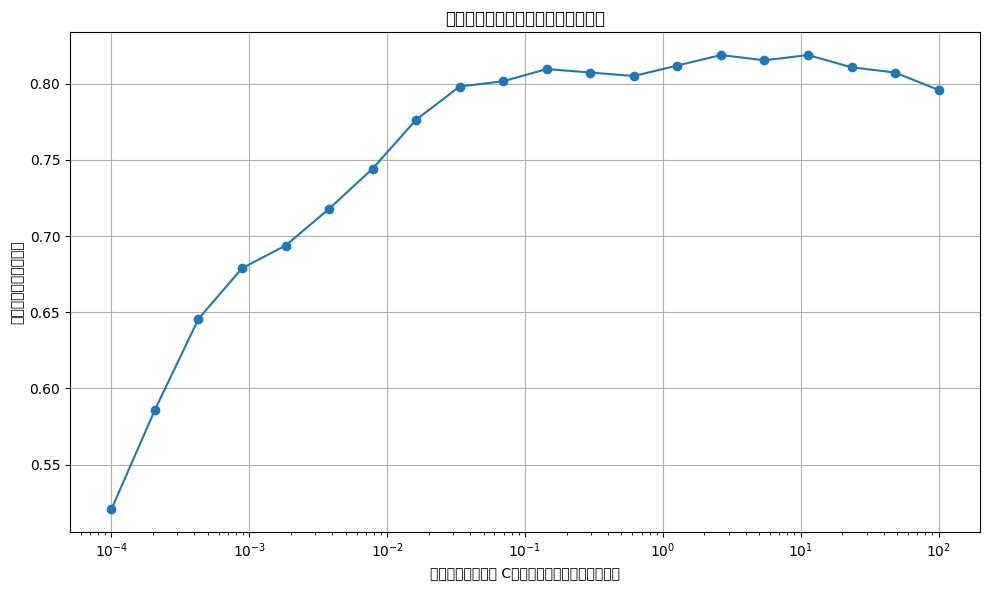

In [21]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Bag of Words に変換
def to_bow_dataset(df):
    dataset = []
    for _, row in df.iterrows():
        text = row["sentence"]
        label = row["label"]
        tokens = text.split()
        feature = {}
        for token in tokens:
            feature[token] = feature.get(token, 0) + 1
        dataset.append({"text": text, "label": str(label), "feature": feature})
    return dataset

train_bow_dataset = to_bow_dataset(train_df)
dev_bow_dataset = to_bow_dataset(dev_df)

# 特徴ベクトルに変換
vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform([ex["feature"] for ex in train_bow_dataset])
y_train = [int(ex["label"]) for ex in train_bow_dataset]

X_dev = vectorizer.transform([ex["feature"] for ex in dev_bow_dataset])
y_dev = [int(ex["label"]) for ex in dev_bow_dataset]

# 正則化パラメータ C を変化させて学習・評価
C_values = np.logspace(-4, 2, 20)
accuracies = []

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_dev)
    acc = accuracy_score(y_dev, y_pred)
    accuracies.append(acc)


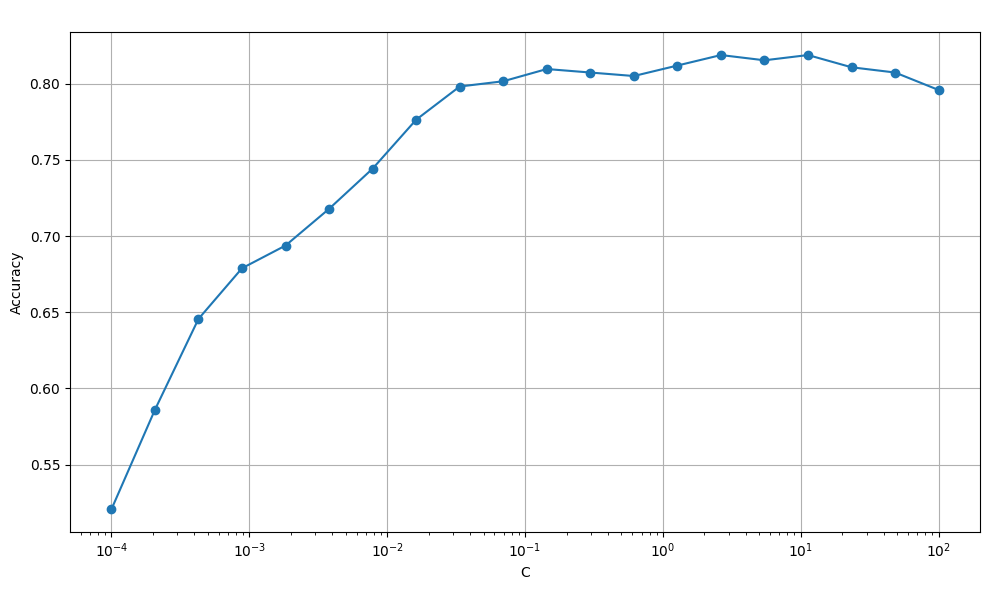

In [23]:

# グラフ描画
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title(" ")
plt.grid(True)
plt.tight_layout()
plt.show()
